## Welcome to Diana's First Jupyter Notebook!
### HW 13

The purpose of this notebook is to show you one way to use linear regressoin to predict stream flow of Verde River. 

Below you will see a code I have made to predict streamflow of the Verde River.

##  Grade - 
6/6 - Very nice first notebook. I like all the elements, its very concise and easy to follow.  

In the future I would suggest:
- Adding a bit more narration to your markdown blocks. They are really useful  for providing more desciprtion to your reader. 
- Taking out some of the things that are currently in the top comments of your code blocks and moveing them to markdown. You still want comments in your code but those sholud be limited to the comments that descibe the code itself.  If they are overview intro stuff or urls and things you should move those to the markdown.
- Add a block to the top of your code with all of the file reads
- Similiarly its good to have a block at the top where you set all of your user defined variables
- Try defining your functions in a separate file.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import fiona
import shapely
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
from shapely.geometry import Point
import contextily as ctx


In [2]:
# Creating my function

def get_mean(days_of_flow):
    """Function to get my mean from x amount of days ago

    This function will give us the mean flows from the *tail* end of our data.
    We can ask it to give us last weeks mean (i.e., last 7 days) or however
    many days we ask it to look back to.

    get_mean is an int or float
    """

    mymean = np.mean(data.tail(days_of_flow)['flow'])
    return mymean

In [3]:
# Below is the USGS streamgauge website that we will read to predict
# streamflow
url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=' \
      'rdb&site_no=09506000&referred_module=sw&period=&begin_date' \
      '=1989-01-01&end_date=2020-11-21'


# Read the data into a pandas dataframe
data = pd.read_table(url, sep='\t', skiprows=30,
                     names=['agency_cd', 'site_no', 'datetime', 'flow',
                            'code'], parse_dates=['datetime'], 
                     )

# Expand the dates to year month day
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).day
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Aggregate flow values to weekly
flow_weekly = data.resample("W", on='datetime').mean()


In [4]:
# Created a for loop to shift/lag my flow data 20 times which also creates
# new columns (1-20) of the shifted flow data.

for k in range(1, 21):
    flow_weekly[k] = flow_weekly['flow'].shift(k)
    
# We are using the entire data set (1989 forward) and chose to use the first
# 1200 weeks for my training set. I dropped the first twenty weeks since
# they didn't have lagged data to go with them. My test set is composed
# of rows 1200 onward.

shifts = list(range(1,21))
shifts_and_flow = ["flow"] + shifts
training_start = 21
training_end = 1200

train = flow_weekly[training_start:training_end][shifts_and_flow]
test = flow_weekly[training_end:][shifts_and_flow]


In [5]:
# This fit my data into a linear regressoin model. My x axis is my shifted flow
# values. My y axis is the flow values.

model = LinearRegression()

x = train[shifts]
y = train['flow'].values
model.fit(x, y)
r_sq = model.score(x, y)
print('The coefficient of determination is:', np.round(r_sq, 2))
print('The Y intercept is:', np.round(model.intercept_, 2))
print('The slopes are:', np.round(model.coef_, 2))

The coefficient of determination is: 0.4
The Y intercept is: 122.62
The slopes are: [ 0.43  0.1  -0.    0.13  0.1   0.19 -0.12 -0.09 -0.02 -0.05 -0.03 -0.
  0.03  0.03  0.01  0.01 -0.01 -0.02 -0.    0.  ]


In [6]:
# Prediction for week 1 using my AR model. I used a for loop that would make a
# line with the equation y = m1x1 + m2x2 ... m20x20 + b

this_week_ARpred = model.intercept_

for f in range(1, 21):
    this_week_ARpred = model.coef_[f-1] * test[f].tail(1) + this_week_ARpred
print("this is the first week AR prediction:", np.int(this_week_ARpred.values))

# Prediction for week 2 using my model. This code uses the weekly flow value 
# predicted above and uses it in the second weeks prediction.
# This is achieved by first setting "next_week_pred" equal to
# model.intercept_, then adding m1 (model.coef_[0]) times x1 (this_week_pred).
# This gave me y= m1x1 + b. Then I only made the for loop go 1-20 (instead of
# 1-21) because my first week was already acounted for. This gave me the
# same equation as above y = m1x1 + m2x2 ... m20x20 + b using my newest
# weekly flow and all other x values shifted by one week.

next_week_ARpred = model.intercept_

next_week_ARpred = this_week_ARpred * model.coef_[0] + next_week_ARpred

for p in range(1, 20):
    next_week_ARpred = model.coef_[p] * test[p].tail(1) + next_week_ARpred

print("this is the second week AR prediction:", np.int(next_week_ARpred))


this is the first week AR prediction: 217
this is the second week AR prediction: 250


### My first figure

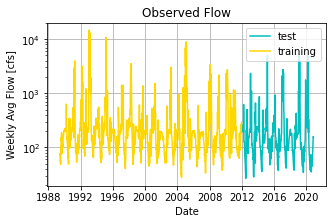

In [7]:
# I am including one graph that shows clearly my training and test data range
fig, ax = plt.subplots()
ax.plot(test['flow'], '-c', label='test')
ax.plot(train['flow'], color='gold', linestyle='-', label='training')
ax.set(title="Observed Flow", xlabel="Date", ylabel="Weekly Avg Flow [cfs]",
       yscale='log')
ax.grid(True)
ax.legend()

# Saving the figure
fig.set_size_inches(5, 3)
fig.savefig("Range of Training and Test Flow.png")

### Below is the code that I will really use to determine weekly flow

The reason why I have chosen to not use my autoregressive model to predict flow is because the coefficient of determination was low (0.4). Thus I have chosen to use deductive reasoning to determine my flow! I will look at the past weeks flow and couple it with pressure trends. These two pieces of information will guide me to my prediction.


In [8]:
# Reading NetCDF data. This data is pressure data from 1989 to present. 

data_path = os.path.join('X68.230.59.40.319.19.13.50.nc')
dataset = xr.open_dataset(data_path)

In [9]:
# Slicing the data for just one point

pres = dataset['pres']
lat = dataset["pres"]["lat"].values[0]
lon = dataset["pres"]["lon"].values[0]
print("Long, Lat values:", lon, lat)
one_point = dataset["pres"].sel(lat=lat,lon=lon)
one_point.shape

# Making NetCDF into a dataframe
one_point_df = one_point.to_dataframe()

# Examing the mean from the last 5 days
print(np.mean(one_point_df.tail(5)))

Long, Lat values: 247.5 35.0
lat        35.0
lon       247.5
pres    88897.5
dtype: float32


### My second figure

This second figure shows the recorded pressure from the last 25 days. I am using this data to inform me whether or not it is going to rain in the next few days. Based on the graph it does not look like the pressure is dropping therefore I predicting no increase in flows.

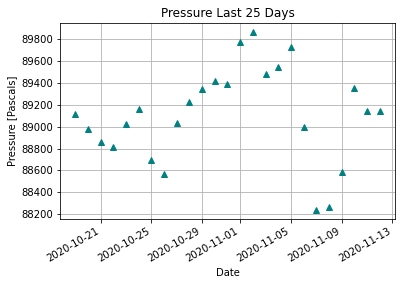

In [10]:
# defining variables to look at the last 25 days of pressure

one_point_df_end25 = one_point_df.tail(25)

# This is a scatter plot of the data from above. It shows where the pressure
# has been throughout the last 25 days. 

one_point_df_end25.reset_index(inplace=True)
y = one_point_df_end25['pres']
x = one_point_df_end25['time']

fig = plt.figure()
plt.plot(x,y,'^', color = 'teal')
plt.xlabel("Date")
plt.title("Pressure Last 25 Days")
plt.ylabel("Pressure [Pascals]")
plt.grid(True)
fig.autofmt_xdate()

In [11]:
# We will use the mean flow values from the past 4 days to determine next
# weeks flow. This is because flow appear to be dropping so I want to
# use the data from the most recent days. Also, based on pressure data I
# not expecting any rain. 

week1_pred = int(get_mean(4))
print("my actual week 1 prediction is", week1_pred)

# I'm assuming my week 2 prediction will be slightly higher based on past
# trends. Therefore I just added 1 cfs for week 2's prediction. 

week2_pred = week1_pred + 1
print("my actual week 2 prediction is", week2_pred)

my actual week 1 prediction is 153
my actual week 2 prediction is 154


In [12]:
# Creating a series for my seasonal flow predictions.
# These are based on wishful thinking. 

seasonal_prediction = pd.Series([58, 45, 40, 51, 57, 56, 65, 70, 80, 90,
110, 115, 700, 300, 400, 400], index= ["lt_week1", "lt_week2", "lt_week3", "lt_week4",
"lt_week5", "lt_week6", "lt_week7", "lt_week8", "lt_week9", "lt_week10", 
"lt_week11", "lt_week12" , "lt_week13", "lt_week14" , "lt_week15", "lt_week16"])
print (seasonal_prediction)

lt_week1      58
lt_week2      45
lt_week3      40
lt_week4      51
lt_week5      57
lt_week6      56
lt_week7      65
lt_week8      70
lt_week9      80
lt_week10     90
lt_week11    110
lt_week12    115
lt_week13    700
lt_week14    300
lt_week15    400
lt_week16    400
dtype: int64


# Map

Below you will see code that produces a map of the watershed as well as shows you where the Verde River is. 

C:\Users\dnahh\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\dnahh\miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-13-ebb3605e589a>:31: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.OpenTopoMap, crs=gages_AZ.crs)


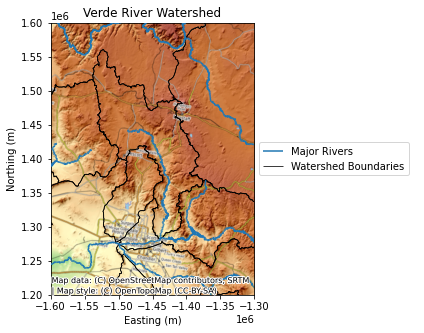

In [13]:
# Gages:
# - https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder
# Rivers and Watersheds:
# - http://uair.library.arizona.edu/item/292543/browse-data/Water?page=1
# HUC 4:
# - https://www.sciencebase.gov/catalog/item/5a96cda0e4b06990606c4d0f

file = os.path.join('gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)
gages_AZ = gages[gages['STATE'] == 'AZ']

file2 = os.path.join('Major Rivers.shp')
major_rivers = gpd.read_file(file2)
major_rivers_project = major_rivers.to_crs(gages_AZ.crs)

file3 = os.path.join('Watersheds.shp')
Watersheds = gpd.read_file(file3)
Watersheds_project = Watersheds.to_crs(gages_AZ.crs)

# Plotting all the layers together
fig, ax = plt.subplots(figsize=(5, 5))
major_rivers_project.plot(ax=ax, zorder=3, label="Major Rivers")
Watersheds_project.boundary.plot(ax=ax, color=None, edgecolor='black',
                                 linewidth=.75, label="Watershed Boundaries",
                                 zorder=1)
ax.set_title("Verde River Watershed")
ax.set(ylim=[1.2e6, 1.6e6], xlim=[-1.6e6, -1.3e6])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ctx.add_basemap(ax, url=ctx.providers.OpenTopoMap, crs=gages_AZ.crs)
plt.savefig("Verde_River_Watershed.png")
plt.show()


## Final Takeaways 

My forecasting has evolved from week 1 to now in several ways! In the beginning I was only guessing my data and printing it. Now I can use linear regression to predict flow, but chose not to because without a careful analysis of which dates to use, the r2 of the predictions are very poor. 

Therefore I made a function that could calculate mean flow from x amount of days previous. This is how I am actually predicting my flows. I am also using additional data from NOAA to get pressure data over the Verde River. This allows my to see whether or not it is likely to rain over the next few days and take that into consideration when I make my predictions. 

I can also plot maps and different style graphs to show the data I have been able to aquire and analyze. 